# <font  color = "#0093AF"> Contact Shifts

The contact and pseudocontact shifts arise from Hyperfine couplings of a nucleus to an electron, where the electron undergoes rapid T$_1$ relaxation. Because of this rapid relaxation, the splitting that would normally be observed on the nucleas is averaged away. However, polarization on the electron means that the nuclear resonance frequency is nonetheless shifted. For an isotropic coupling, this is the "Contact Shift" which can be simply demonstrated. We start by showing the spectrum without any relaxation on the electron, but with some polarization.

In [83]:
# Imports
import sys,os
sys.path.append(os.path.expanduser('~/Documents/GitHub/'))
import SLEEPY as sl
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt
sl.Defaults['verbose']=False
sl.Defaults['ctype']=np.complex256
sl.Defaults['parallel']=False

In [2]:
%matplotlib notebook

## Part 1: Contact shift

### Isotropic coupling

<IPython.core.display.Javascript object>


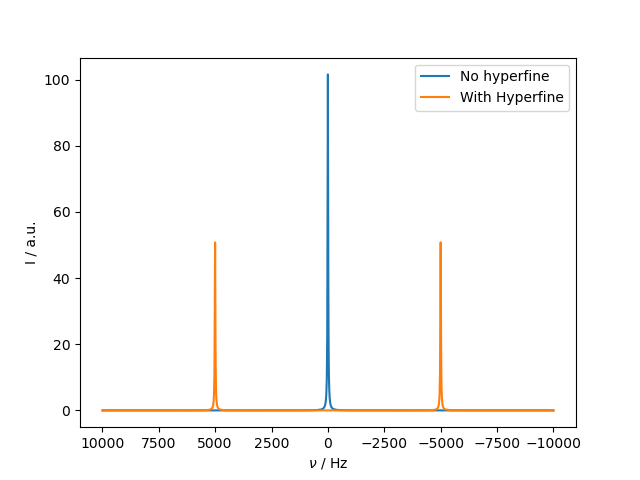

In [22]:
A=10000    #Isotropic coupling
Dt=5e-5    #Timestep (required for static experiments)
n=1024     #Number of time points

ex=sl.ExpSys(v0H=600,Nucs=['1H','e'],T_K=275)  #Electron-nuclear system

L=ex.Liouvillian()        #Generate a Liouvillian

seq=L.Sequence(Dt=Dt) #Generate an empty sequence

rho=sl.Rho('1Hx','1Hp')   #Generate initial state, detection operator
rho.DetProp(seq,n=n)   #Propagate the system
ax=rho.plot(FT=True,apodize=True)      #Plot the results (no hyperfine added yet)

ex.set_inter('hyperfine',i0=0,i1=1,Axx=A,Ayy=A,Azz=A)   #Isotropic hyperfine coupling

L=ex.Liouvillian()        #Liouvillian needs reinitialized for new interaction
seq=L.Sequence(Dt=Dt) #Generate an empty sequence

rho.clear()             #Clear density operator
rho.DetProp(seq,n=n) #Propagate the system
rho.plot(FT=True,apodize=True,ax=ax) #Plot the results into the same axis
_=ax.legend(('No hyperfine','With Hyperfine'))

As expected, the main peak splits into two. We can also induce polarization on the electron by starting from thermal equilibrium. This requires an additional $\pi/2$ pulse to then generate the desired coherence.

<IPython.core.display.Javascript object>


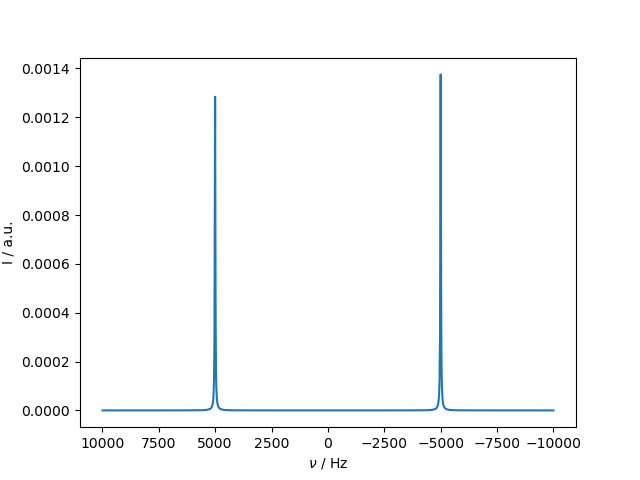

In [23]:
Upi2=L.Udelta('1H',pi/2,phase=pi/2)

rho=sl.Rho('Thermal','1Hp')  #Generate initial state, detection operator
(Upi2*rho).DetProp(seq,n=n) #Propagate the system
_=rho.plot(FT=True,apodize=True) #Plot the results into the same axis

In [24]:
print(f'Electron polarization is {ex.Peq[1]*100:.1f} %')

Electron polarization is -3.4 %


The peak to the right is slightly taller than that to the left, due to a finite electron polarization (3.4 %).

Then, if a fast electron T$_1$ is present, these peaks will merge together, but will shift slightly to the right.

<IPython.core.display.Javascript object>


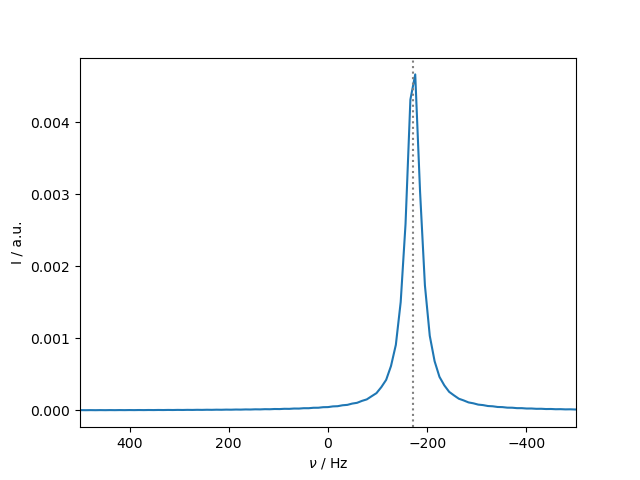

In [25]:
L.clear_relax()                #Not necessary on first run, but usually a good idea in case relaxation present
L.add_relax('T1',i=1,T1=1e-8)  #10 ns T1
L.add_relax('T2',i=1,T2=1e-10) #100 ps T2, required for physical system when T1 is present
L.add_relax('recovery')        #Thermalizes the system. If this is not present, electron polarization will vanish

# Note that when a system is thermalized, we automatically start from thermalized coherences
# so pi/2 pulse is not necessary
rho=sl.Rho('1Hx','1Hp')  #Generate initial state, detection operator
rho.DetProp(seq,n=n) #Propagate the system
ax=rho.plot(FT=True,apodize=True) #Plot the results into the same axis
ax.set_xlim([500,-500])
ax.set_ylim(ax.get_ylim())

_=ax.plot(ex.Peq[1]*A/2*np.ones(2),ax.get_ylim(),color='grey',linestyle=':')

We can, in fact, calculate the extent of the shift. $P_{eq}(e-)$ is the difference of the electron spin-up and spin-down configurations. Then the population of spin-up is $1/2+P_{eq}/2$, and spin-down is $1/2-P_{eq}/2$ so the contact shift is
$$
\delta_{CS}=\left(\frac12+\frac{P_{eq}}2\right)\left(\frac{A_{iso}}2\right)-\left(\frac12+\frac{P_{eq}}2\right)\left(-\frac{A_{iso}}2\right)=\frac12P_{eq}A_{iso}
$$
We test this formula below (note that a line has already been placed on the plot above using this formula). Indeed, the contact shift is easily determined from the isotropic hyperfine coupling and the electron polarization.

In [26]:
print(f'The predicted contact shift is {ex.Peq[1]*A/2:.0f} Hz')

The predicted contact shift is -172 Hz


Note that a key component of the contact and pseudocontact shifts is there temperature dependence. As the electron polarization gets larger, the effect also grows. We can demonstrate this with the above example, while decreasing the temperature.

<IPython.core.display.Javascript object>


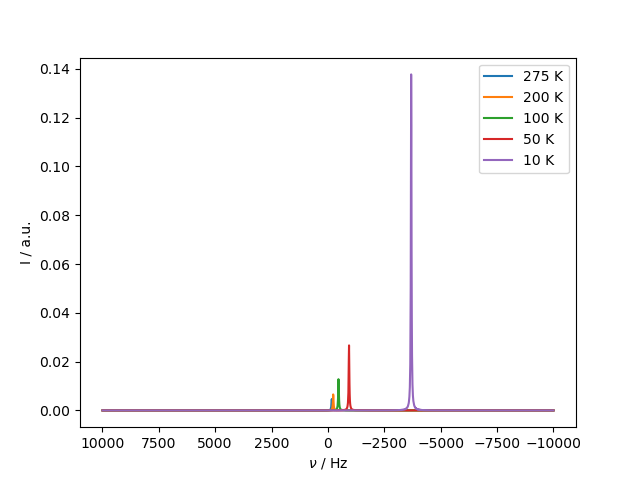

In [29]:
ax=plt.subplots()[1]
T=[275,200,100,50,10]
for T0 in T:
    ex.T_K=T0
    # Thermalization needs to be re-initialized when the temperature is changed
    L.clear_relax()                #Not necessary on first run, but usually a good idea in case relaxation present
    L.add_relax('T1',i=1,T1=1e-8)  #10 ns T1
    L.add_relax('T2',i=1,T2=1e-10) #100 ps T2, required for physical system when T1 is present
    L.add_relax('recovery')        #Thermalizes the system. If this is not present, electron polarization will vanish
    
    rho=sl.Rho('1Hx','1Hp')  #Generate initial state, detection operator
    rho.DetProp(seq,n=n) #Propagate the system
    rho.plot(FT=True,apodize=True,ax=ax) #Plot the results into the same axis
ax.legend([f'{T0} K' for T0 in T])

As the temperature is lowered, we observe an increasing contact shift, as well as increasing signal (simply due to the higher $^1$H polarization).

### Dipolar coupling

The contact shift also arises for a dipolar coupling in the static case.

In [2]:
delta=sl.Tools.dipole_coupling(1.2,'e-','1H')    #15 Angstroms from electron
Dt=5e-6    #Timestep (required for static experiments)
n=512     #Number of time points

<IPython.core.display.Javascript object>


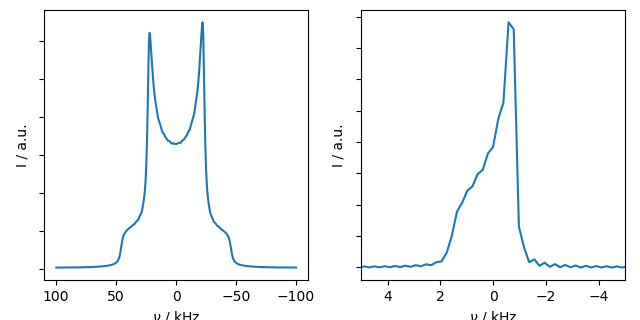

In [39]:
delta=sl.Tools.dipole_coupling(1.2,'e-','1H')    #15 Angstroms from electron
Dt=5e-6    #Timestep (required for static experiments)
n=512     #Number of time points

ex=sl.ExpSys(v0H=600,Nucs=['1H','e'],vr=0,T_K=275,pwdavg=sl.PowderAvg('zcw4180'))  #Electron-nuclear system
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)

L=ex.Liouvillian()        #Generate a Liouvillian
seq=L.Sequence(Dt=Dt) #Generate an empty sequence
Upi2=L.Udelta('1H',pi/2,pi/2)

fig,ax=plt.subplots(1,2)

rho=sl.Rho('Thermal','1Hp')  #Generate initial state, detection operator
rho.apod_pars.update({'WDW':'em','LB':3000})
(Upi2*rho).DetProp(seq,n=n) #Propagate the system
rho.plot(FT=True,apodize=True,ax=ax[0],axis='kHz') #Plot the results into the same axis

L.add_relax('T1',i=1,T1=1e-8)  #10 ns T1
L.add_relax('T2',i=1,T2=1e-10) #100 ps T2, required for physical system when T1 is present
L.add_relax('recovery')        #Thermalizes the system. If this is not present, electron polarization will vanish

rho.clear()
rho.apod_pars.update({'WDW':'em','LB':100})
(Upi2*rho).DetProp(seq,n=n) #Propagate the system
rho.plot(FT=True,apodize=True,ax=ax[1],axis='kHz')
ax[1].set_xlim([5,-5])
for a in ax:a.set_yticklabels([])
fig.set_size_inches(6.4,3.2)
fig.tight_layout()

We see that the Pake pattern is tilted to one side, due to the elecron polarization. When electron $T_1$ is introduced, the Pake pattern averages out, yielding just one much narrower lineshape (although still retaining the form of a rank-2 tensor).

### Dipolar coupling with isotropic motion or MAS

So, what happens to the dipolar pattern under isotropic conditions (tumbling) or MAS? We start with MAS.

<IPython.core.display.Javascript object>


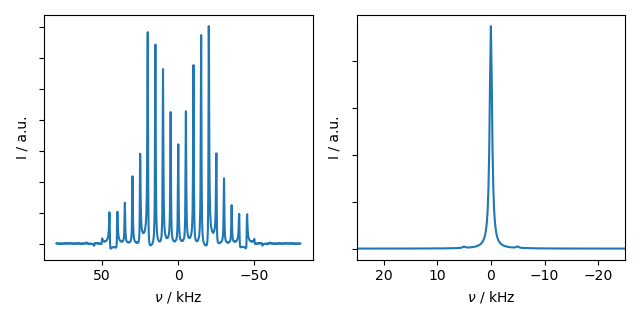

In [50]:
ex=sl.ExpSys(v0H=600,Nucs=['1H','e'],vr=5000,T_K=275)  #Electron-nuclear system
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)

L=ex.Liouvillian()        #Generate a Liouvillian
seq=L.Sequence() #Generate an empty sequence
Upi2=L.Udelta('1H',pi/2,pi/2)

fig,ax=plt.subplots(1,2)

rho=sl.Rho('Thermal','1Hp')  #Generate initial state, detection operator
(Upi2*rho).DetProp(seq,n=n,n_per_seq=32) #Propagate the system
rho.plot(FT=True,apodize=True,ax=ax[0],axis='kHz') #Plot the results into the same axis

L.add_relax('T1',i=1,T1=1e-8)  #10 ns T1
L.add_relax('T2',i=1,T2=1e-10) #100 ps T2, required for physical system when T1 is present
L.add_relax('recovery')        #Thermalizes the system. If this is not present, electron polarization will vanish

rho.clear()
(Upi2*rho).DetProp(seq,n=n,n_per_seq=32) #Propagate the system
rho.plot(FT=True,apodize=True,ax=ax[1],axis='kHz')
ax[1].set_xlim([25,-25])
for a in ax:a.set_yticklabels([])
fig.set_size_inches(6.4,3.2)
fig.tight_layout()

The contact shift emerging from the dipolar part of the hyperfine coupling is fully isotropic, so it is removed by MAS. Here, we use relatively slow spinning, so some sideband does emerge from the dipolar contact shift.

We can also consider a motion that causes isotropic sampling of the hyperfine coupling, to mimic tumbling

<AxesSubplot:xlabel='$\\nu$ / kHz', ylabel='I / a.u.'>

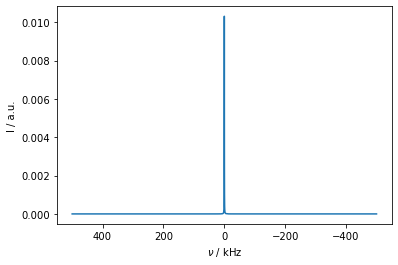

In [8]:
delta=sl.Tools.dipole_coupling(1.2,'e-','1H')    #15 Angstroms from electron
ex=[sl.ExpSys(v0H=600,Nucs=['1H','e'],vr=0,T_K=275,pwdavg=sl.PowderAvg('alpha0beta0'))]  #Electron-nuclear system
ex[-1].set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta,euler=[0,0,0])
for k in range(2):
    ex.append(ex[0].copy())
    ex[-1].set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta,euler=[0,pi/2,k*np.pi/2])

L=sl.Liouvillian(ex)        #Generate a Liouvillian
L.kex=sl.Tools.nSite_sym(n=3,tc=1e-9)  #Exchange between four tetrahedral sites
seq=L.Sequence(Dt=1e-6) #Generate an empty sequence
Upi2=L.Udelta('1H',pi/2,pi/2)

rho=sl.Rho('Thermal','1Hp')  #Generate initial state, detection operator
(Upi2*rho).DetProp(seq,n=4096,n_per_seq=32) #Propagate the system
rho.plot(FT=True,apodize=True,axis='kHz') #Plot the results into the same axis

Even without introducing any electron relaxation, the motion averages the hyperfine to zero, so there is no opportunity to see the contact shift in this case.

## Part 2: Pseudocontact Shift

This brings us to the second part, the pseudocontact shift, which works through the dipole coupling, but does not get averaged away by MAS or isotropic motion. This is due to complex interactions between the hyperfine and g-tensors on the electron.

<IPython.core.display.Javascript object>


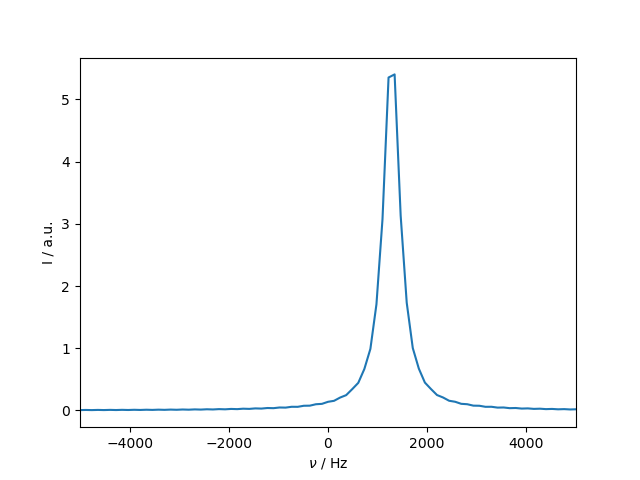

In [19]:
delta=sl.Tools.dipole_coupling(1.2,'e-','1H')    #12 Angstroms from electron
tetra=np.pi-np.arccos(1/3)
ex=[sl.ExpSys(v0H=600,Nucs=['1H','e'],vr=0,LF=True,T_K=1,pwdavg=sl.PowderAvg()[20])]  #Electron-nuclear system
ex[-1].set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta,euler=[0,0,0])
ex[-1].set_inter('g',i=1,gxx=1,gyy=1,gzz=4,euler=[0,0,0])
for k in range(3):
    ex.append(ex[0].copy())
    ex[-1].set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta,euler=[0,tetra,2*k*np.pi/3])
    ex[-1].set_inter('g',i=1,gxx=1,gyy=1,gzz=4,euler=[[0,np.pi/3,0],[0,tetra,2*k*np.pi/3]])
    
L=sl.Liouvillian(ex)        #Generate a Liouvillian
L.kex=sl.Tools.nSite_sym(n=4,tc=1e-9)  #Exchange between four tetrahedral sites

L.add_relax('T1',i=1,T1=1e-9)  #10 ns T1
L.add_relax('T2',i=1,T2=1e-9) #100 ps T2, required for physical system when T1 is present
L.add_relax('recovery')        #Thermalizes the system. If this is not present, electron polarization will vanish

seq=L.Sequence(Dt=1e-6) #Generate an empty sequence
Upi2=L.Udelta('1H',pi/2,pi/2)

rho=sl.Rho('Thermal','1Hp')  #Generate initial state, detection operator
(Upi2*rho).DetProp(seq,n=4096) #Propagate the system
ax=rho.plot(FT=True,apodize=True) #Plot the results into the same axis
_=ax.set_xlim([-5000,5000])

### Pseudocontact shift in solid-state

<IPython.core.display.Javascript object>


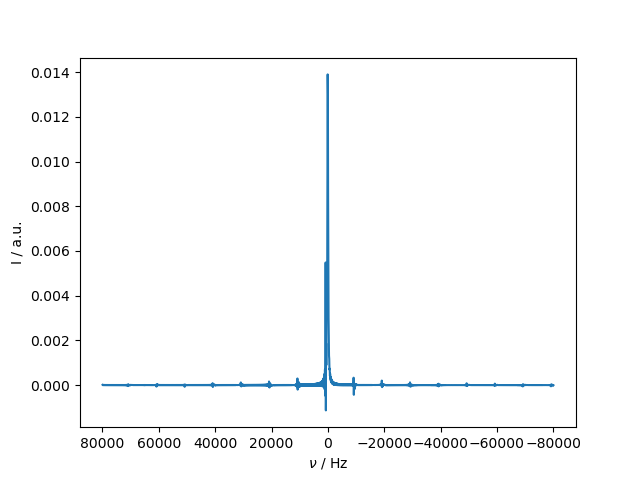

In [80]:
delta=sl.Tools.dipole_coupling(1.2,'e-','13C')    #12 Angstroms from electron
ex=sl.ExpSys(v0H=600,Nucs=['13C','e-'],vr=10000,LF=True,T_K=20,pwdavg=sl.PowderAvg(q=2))  #Electron-nuclear system
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex.set_inter('g',i=1,gxx=1,gyy=1,gzz=4,euler=[0,2*np.pi/5,0])
    
L=sl.Liouvillian(ex)        #Generate a Liouvillian

L.add_relax('T1',i=1,T1=1e-9)  #1 microsecond T1
L.add_relax('T2',i=1,T2=1e-12) #1 ns T2, required for physical system when T1 is present
L.add_relax('Thermal')        #Thermalizes the system. If this is not present, electron polarization will vanish

seq=L.Sequence() #Generate an empty sequence
Upi2=L.Udelta('13C',pi/2,pi/2)

rho=sl.Rho('Thermal','13Cp')  #Generate initial state, detection operator
(Upi2*rho).DetProp(seq,n=1000,n_per_seq=16) #Propagate the system
rho.downmix()
ax=rho.plot(FT=True,apodize=True) #Plot the results into the same axis

<IPython.core.display.Javascript object>


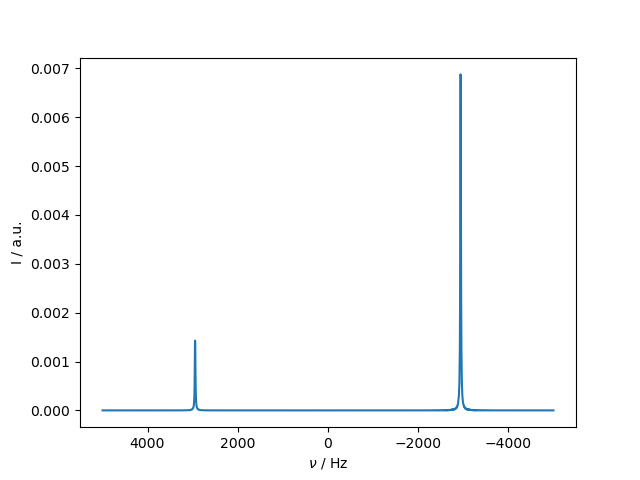

In [90]:
delta=sl.Tools.dipole_coupling(1.2,'e-','13C')    #12 Angstroms from electron
ex=sl.ExpSys(v0H=600,Nucs=['13C','e-'],vr=0,LF=True,T_K=20,pwdavg=sl.PowderAvg(q=2)[10])  #Electron-nuclear system
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex.set_inter('g',i=1,gxx=1,gyy=1,gzz=4,euler=[0,2*np.pi/5,0])
    
L=sl.Liouvillian(ex)        #Generate a Liouvillian

# L.add_relax('T1',i=1,T1=1e-6)  #1 microsecond T1
# L.add_relax('T2',i=1,T2=1e-12) #1 ns T2, required for physical system when T1 is present
# L.add_relax('Thermal')        #Thermalizes the system. If this is not present, electron polarization will vanish

seq=L.Sequence(Dt=1/10000) #Generate an empty sequence
Upi2=L.Udelta('13C',pi/2,pi/2)

rho=sl.Rho('Thermal','13Cp')  #Generate initial state, detection operator
(Upi2*rho).DetProp(seq,n=1000,n_per_seq=16) #Propagate the system
rho.downmix()
ax=rho.plot(FT=True,apodize=True) #Plot the results into the same axis

In [86]:
delta

-23015.036575727347